In [29]:
import tensorflow as tf
import cv2 as cv
import os
import pandas as pd
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from math import floor, ceil, pi
import scipy.misc
import glob
import imageio # for saving image file
import tensorflow_addons as tfa # for rotating image

In [30]:
def get_image_paths():
    folder = "../gauges"
    files = os.listdir(folder)
    files.sort()
    files = ["{}/{}".format(folder, file) for  file in files]
    return files

In [6]:
# os.mkdir("../img_prep/reduc2_prep_gauge384")

In [31]:
for dirpath, dirnames, filenames in os.walk("../img_prep/prep_gauge384"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} ")

There are 0 directories and 0 images in ../img_prep/prep_gauge384 


In [32]:
X_img_paths = get_image_paths()
print(X_img_paths[:])

['../gauges/gauge_-0.0.png', '../gauges/gauge_-0.1.png', '../gauges/gauge_-0.2.png', '../gauges/gauge_-0.3.png', '../gauges/gauge_-0.4.png', '../gauges/gauge_-0.5.png', '../gauges/gauge_-0.6.png', '../gauges/gauge_-0.7.png', '../gauges/gauge_-0.8.png', '../gauges/gauge_-0.9.png', '../gauges/gauge_-1.0.png', '../gauges/gauge_0.1.png', '../gauges/gauge_0.2.png', '../gauges/gauge_0.3.png', '../gauges/gauge_0.4.png', '../gauges/gauge_0.5.png', '../gauges/gauge_0.6.png', '../gauges/gauge_0.7.png', '../gauges/gauge_0.8.png', '../gauges/gauge_0.9.png', '../gauges/gauge_1.0.png', '../gauges/gauge_1.1.png', '../gauges/gauge_1.2.png', '../gauges/gauge_1.3.png', '../gauges/gauge_1.4.png', '../gauges/gauge_1.5.png', '../gauges/gauge_1.6.png', '../gauges/gauge_1.7.png', '../gauges/gauge_1.8.png', '../gauges/gauge_1.9.png', '../gauges/gauge_2.0.png', '../gauges/gauge_2.1.png', '../gauges/gauge_2.2.png', '../gauges/gauge_2.3.png', '../gauges/gauge_2.4.png', '../gauges/gauge_2.5.png', '../gauges/gauge

In [33]:
def tf_resize_img(X_img_file_paths, img_shape=384):
    X_data = []

# Individually resize image
    for index, file_path in enumerate(X_img_file_paths):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.image.resize(img, size=[img_shape, img_shape])
        img = img/225.
        X_data.append(img)

    X_data = np.array(X_data, dtype=np.float32)
    return X_data

In [34]:
X_imgs = tf_resize_img(X_img_paths[:])
print(X_imgs.shape)

(41, 384, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


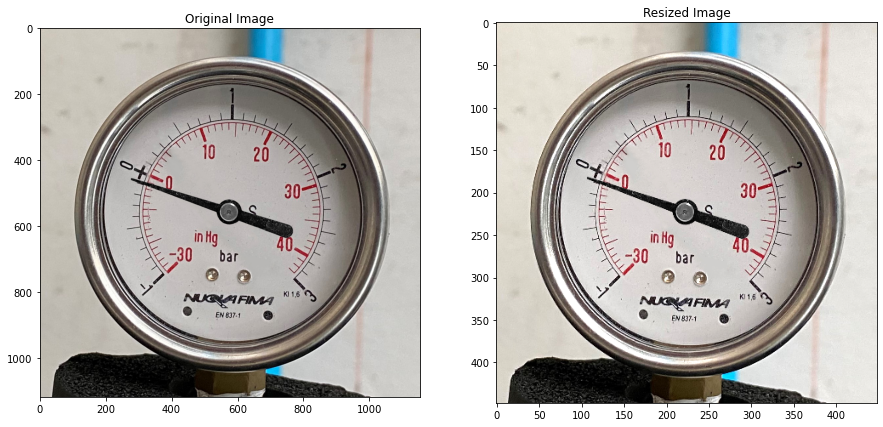

In [8]:
plt.figure(figsize=(15,15))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(X_img_paths[1])[:,:,:3])
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(X_imgs[1])
plt.title("Resized Image")
plt.show()

## Scaling

In [35]:
def central_scale_images(X_imgs, scales, img_shape=384):
    boxes = np.zeros((len(scales), 4), dtype=np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype=np.float32)
    box_ind = np.zeros(len(scales), dtype=np.int32)
    crop_size = np.array([img_shape, img_shape], dtype=np.int32)

    X_scale_data= []
    for img_data in X_imgs:
        batch_img = tf.expand_dims(img_data, axis=0) # expand dimension of input image to 4 dims
        tf_img = tf.image.crop_and_resize(batch_img, boxes, box_ind, crop_size) # require 4 dims input
        X_scale_data.extend(tf_img)

    X_scale_data = np.array(X_scale_data, dtype=np.float32)
    return X_scale_data

In [10]:
scale_imgs = central_scale_images(X_imgs[:], np.linspace(0.6, 0.9))
print(scale_imgs.shape)

(2050, 448, 448, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Scale=0.90')

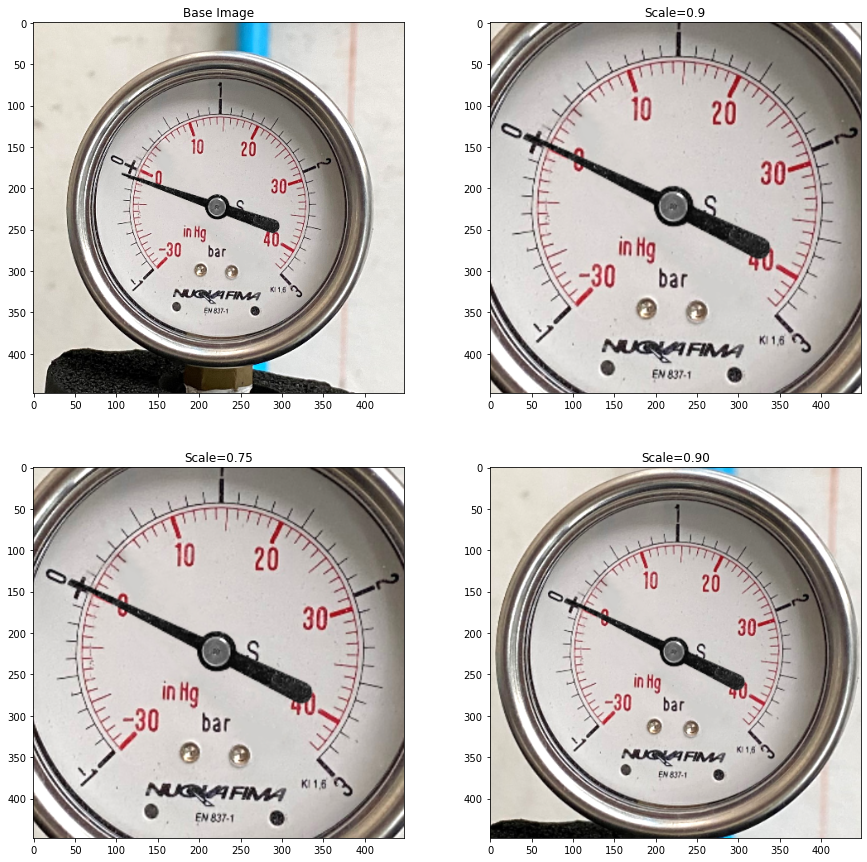

In [11]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(X_imgs[1])
plt.title("Base Image")
plt.subplot(2,2,2)
plt.imshow(scale_imgs[3])
plt.title("Scale=0.9")
plt.subplot(2,2,3)
plt.imshow(scale_imgs[4])
plt.title("Scale=0.75")
plt.subplot(2,2,4)
plt.imshow(scale_imgs[40])
plt.title("Scale=0.90")

## Translation

In [36]:
IMAGE_SIZE = 384

In [39]:
def get_translate_parameter(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    elif index == 3: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE
    elif index == 4: # Translate left 10 percent
        offset = np.array([0.0, 0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.9 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 5: # Translate right 10 percent
        offset = np.array([0.0, -0.1], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.9 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE 
    elif index == 6: # Translate top 10 percent
        offset = np.array([0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.9 * IMAGE_SIZE))  
    elif index == 7: # Translate bottom 10 percent
        offset = np.array([-0.1, 0.0], dtype = np.float32)
        size = np.array([ceil(0.9 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.9) * IMAGE_SIZE))
        h_end = IMAGE_SIZE      
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype=np.float32)
    n_translates=8
    X_translated_arr = []

    for i in range(n_translates):
        X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        X_translated.fill(1.0) # filling background color
        base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameter(i)
        offsets[:, :] = base_offset
        glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
        X_translated[:, h_start: h_start + size[0],
                     w_start: w_start + size[1], :] = glimpses
        X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype=np.float32)
    return X_translated_arr

In [12]:
# def get_translate_parameter(index):
#     if index == 0: # Translate left 25 percent
#         offset = np.array([0.0, 0.25], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.75 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.70 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 1: # Translate right 25 percent
#         offset = np.array([0.0, -0.25], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.75 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.75) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 2: # Translate top 25 percent
#         offset = np.array([0.25, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.75 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.75 * IMAGE_SIZE)) 
#     elif index == 3: # Translate bottom 25 percent
#         offset = np.array([-0.25, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.75 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.75) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE
#     elif index == 4: # Translate left 24 percent
#         offset = np.array([0.0, 0.24], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.76 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.76 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 5: # Translate right 24 percent
#         offset = np.array([0.0, -0.24], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.76 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.76) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 6: # Translate top 24 percent
#         offset = np.array([0.24, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.76 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.76 * IMAGE_SIZE)) 
#     elif index == 7: # Translate bottom 24 percent
#         offset = np.array([-0.24, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.76 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.76) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE
#     elif index == 8: # Translate left 23 percent
#         offset = np.array([0.0, 0.23], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.77 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.77 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 9: # Translate right 23 percent
#         offset = np.array([0.0, -0.23], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.77 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.77) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 10: # Translate top 23 percent
#         offset = np.array([0.23, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.77 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.77 * IMAGE_SIZE)) 
#     elif index == 11: # Translate bottom 23 percent
#         offset = np.array([-0.23, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.77 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.77) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE
#     elif index == 12: # Translate left 22 percent
#         offset = np.array([0.0, 0.22], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.78 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.78 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 13: # Translate right 22 percent
#         offset = np.array([0.0, -0.22], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.78 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.78) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 14: # Translate top 22 percent
#         offset = np.array([0.22, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.78 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.78 * IMAGE_SIZE))  
#     elif index == 15: # Translate bottom 22 percent
#         offset = np.array([-0.22, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.78 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.78) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE  
#     elif index == 16: # Translate left 21 percent
#         offset = np.array([0.0, 0.21], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.79 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.79 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 17: # Translate right 21 percent
#         offset = np.array([0.0, -0.21], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.79 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.79) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 18: # Translate top 21 percent
#         offset = np.array([0.21, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.79 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.79 * IMAGE_SIZE))  
#     elif index == 19: # Translate bottom 21 percent
#         offset = np.array([-0.21, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.79 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.79) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE  
#     elif index == 20: # Translate left 20 percent
#         offset = np.array([0.0, 0.20], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.80 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.80 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 21: # Translate right 20 percent
#         offset = np.array([0.0, -0.20], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.80 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.80) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 22: # Translate top 20 percent
#         offset = np.array([0.20, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.80 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.80 * IMAGE_SIZE))  
#     elif index == 23: # Translate bottom 20 percent
#         offset = np.array([-0.20, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.80 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.80) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE   
#     elif index == 24: # Translate left 19 percent
#         offset = np.array([0.0, 0.19], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.81 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.81 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 25: # Translate right 19 percent
#         offset = np.array([0.0, -0.19], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.81 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.81) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 26: # Translate top 19 percent
#         offset = np.array([0.19, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.81 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.81 * IMAGE_SIZE))  
#     elif index == 27: # Translate bottom 19 percent
#         offset = np.array([-0.19, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.81 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.81) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE
#     elif index == 28: # Translate left 18 percent
#         offset = np.array([0.0, 0.18], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.82 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.82 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 29: # Translate right 18 percent
#         offset = np.array([0.0, -0.18], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.82 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.82) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 30: # Translate top 18 percent
#         offset = np.array([0.18, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.82 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.82 * IMAGE_SIZE))  
#     elif index == 31: # Translate bottom 18 percent
#         offset = np.array([-0.18, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.82 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.82) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE 
#     elif index == 32: # Translate left 17 percent
#         offset = np.array([0.0, 0.17], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.83 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.83 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 33: # Translate right 17 percent
#         offset = np.array([0.0, -0.17], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.83 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.83) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 34: # Translate top 17 percent
#         offset = np.array([0.17, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.83 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.83 * IMAGE_SIZE))  
#     elif index == 35: # Translate bottom 17 percent
#         offset = np.array([-0.17, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.83 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.83) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE
#     elif index == 36: # Translate left 16 percent
#         offset = np.array([0.0, 0.16], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.84 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.84 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 37: # Translate right 16 percent
#         offset = np.array([0.0, -0.16], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.84 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.84) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 38: # Translate top 16 percent
#         offset = np.array([0.16, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.84 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.83 * IMAGE_SIZE))  
#     elif index == 39: # Translate bottom 16 percent
#         offset = np.array([-0.16, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.84 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.84) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE 
#     elif index == 40: # Translate left 15 percent
#         offset = np.array([0.0, 0.15], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.85 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.85 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 41: # Translate right 15 percent
#         offset = np.array([0.0, -0.15], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.85 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.85) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 42: # Translate top 15 percent
#         offset = np.array([0.15, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.85 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.85 * IMAGE_SIZE))  
#     elif index == 43: # Translate bottom 14 percent
#         offset = np.array([-0.15, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.85 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.85) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE 
#     elif index == 44: # Translate left 14 percent
#         offset = np.array([0.0, 0.14], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.86 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.86 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 45: # Translate right 14 percent
#         offset = np.array([0.0, -0.14], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.86 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.86) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 46: # Translate top 14 percent
#         offset = np.array([0.14, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.86 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.86 * IMAGE_SIZE))  
#     elif index == 47: # Translate bottom 14 percent
#         offset = np.array([-0.14, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.86 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.86) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE 
#     elif index == 48: # Translate left 13 percent
#         offset = np.array([0.0, 0.13], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.87 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.87 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 49: # Translate right 13 percent
#         offset = np.array([0.0, -0.13], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.87 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.87) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 50: # Translate top 13 percent
#         offset = np.array([0.13, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.87 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.87 * IMAGE_SIZE))  
#     elif index == 51: # Translate bottom 13 percent
#         offset = np.array([-0.13, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.87 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.87) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE 
#     elif index == 52: # Translate left 12 percent
#         offset = np.array([0.0, 0.12], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.88 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.88 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 53: # Translate right 12 percent
#         offset = np.array([0.0, -0.12], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.88 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.88) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 54: # Translate top 12percent
#         offset = np.array([0.12, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.88 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.88 * IMAGE_SIZE))  
#     elif index == 55: # Translate bottom 12 percent
#         offset = np.array([-0.12, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.88 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.88) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE 
#     elif index == 56: # Translate left 11 percent
#         offset = np.array([0.0, 0.11], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.89 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.89 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 57: # Translate right 11 percent
#         offset = np.array([0.0, -0.11], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.89 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.89) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 58: # Translate top 11 percent
#         offset = np.array([0.11, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.89 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.89 * IMAGE_SIZE))  
#     elif index == 59: # Translate bottom 11 percent
#         offset = np.array([-0.11, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.89 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.89) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE
#     elif index == 60: # Translate left 10 percent
#         offset = np.array([0.0, 0.10], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.90 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = 0
#         w_end = int(ceil(0.90 * IMAGE_SIZE))
#         h_start = 0
#         h_end = IMAGE_SIZE
#     elif index == 61: # Translate right 10 percent
#         offset = np.array([0.0, -0.10], dtype = np.float32)
#         size = np.array([IMAGE_SIZE, ceil(0.90 * IMAGE_SIZE)], dtype = np.int32)
#         w_start = int(floor((1 - 0.90) * IMAGE_SIZE))
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = IMAGE_SIZE 
#     elif index == 62: # Translate top 10 percent
#         offset = np.array([0.10, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.90 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = 0
#         h_end = int(ceil(0.90 * IMAGE_SIZE))  
#     elif index == 63: # Translate bottom 10 percent
#         offset = np.array([-0.10, 0.0], dtype = np.float32)
#         size = np.array([ceil(0.90 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
#         w_start = 0
#         w_end = IMAGE_SIZE
#         h_start = int(floor((1 - 0.90) * IMAGE_SIZE))
#         h_end = IMAGE_SIZE 


#     return offset, size, w_start, w_end, h_start, h_end

# def translate_images(X_imgs):
#     offsets = np.zeros((len(X_imgs), 2), dtype=np.float32)
#     n_translates=64
#     X_translated_arr = []

#     for i in range(n_translates):
#         X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
#         X_translated.fill(1.0) # filling background color
#         base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameter(i)
#         offsets[:, :] = base_offset
#         glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
#         X_translated[:, h_start: h_start + size[0],
#                      w_start: w_start + size[1], :] = glimpses
#         X_translated_arr.extend(X_translated)
#     X_translated_arr = np.array(X_translated_arr, dtype=np.float32)
#     return X_translated_arr

In [40]:
translated_imgs = translate_images(X_imgs[:])
print(translated_imgs.shape)

(328, 384, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


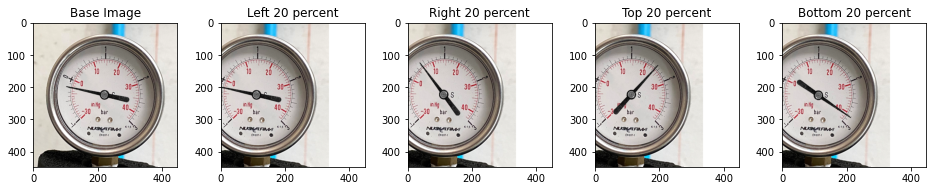

In [16]:
gs =  gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[14])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[26])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[38])
plt.title('Bottom 20 percent')
plt.show()

## Rotation

In [46]:
def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    for index in range(n_images):
        degree_angle = start_angle + index * iterate_at
        radian_value = degree_angle * pi / 180 # convert  to radian
        radian_arr = [radian_value] * len(X_imgs)
        rotated_imgs = tfa.image.rotate(X_imgs, radian_arr)
        X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype=np.float32)
    return X_rotate 

In [47]:
rotated_imgs = rotate_images(X_imgs[:], -90, 90, 4)
print(rotated_imgs.shape)

(164, 384, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

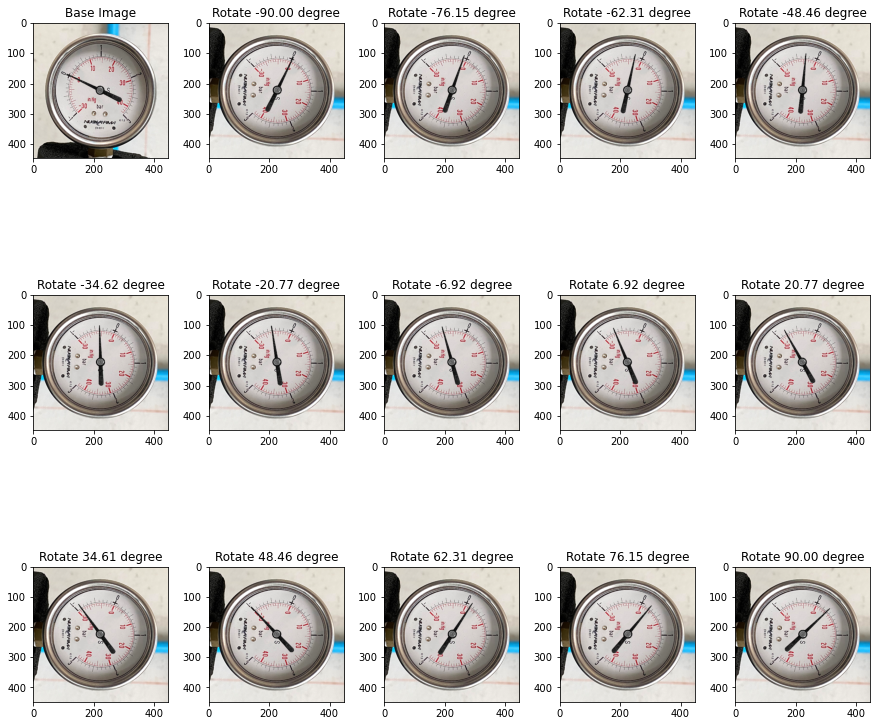

In [19]:
plt.figure(figsize=(15,15))
gs = gridspec.GridSpec(3,5)
gs.update(wspace = 0.30, hspace = 0.0002)

plt.subplot(gs[0])
plt.imshow(X_imgs[0])
plt.title("Base Image")

for i in range(14):
    plt.subplot(gs[i+1])
    plt.imshow(rotated_imgs[i])
    plt.title("Rotate {:.2f} degree".format(-90 + 13.846 * i))
plt.show()

## Light Condition

In [14]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    count=0
    # Gaussian distribution paramaters
    mean = 0
    var = 0.1
    sigma = var ** 0.5

    # parameters of method cv.addWeighted
    ALPHA = np.linspace(0.50, 0.85, 2)
    BETA = np.linspace(0.2, 0.8, 2)

    for X_img in X_imgs:
        for alpha in ALPHA:
            for beta in BETA:
                gaussian = np.random.random((row, col, 1)).astype(np.float32)
                gaussian = np.concatenate((gaussian, gaussian, gaussian), axis=2)
                gaussian_img = cv.addWeighted(X_img, alpha, (1-alpha) * gaussian, beta, 0)
                gaussian_noise_imgs.append(gaussian_img)
                

    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype=np.float32)
    return gaussian_noise_imgs

In [19]:
gaussian_noise_imgs = add_gaussian_noise(X_imgs[:])
print(gaussian_noise_imgs.shape)

(164, 384, 384, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


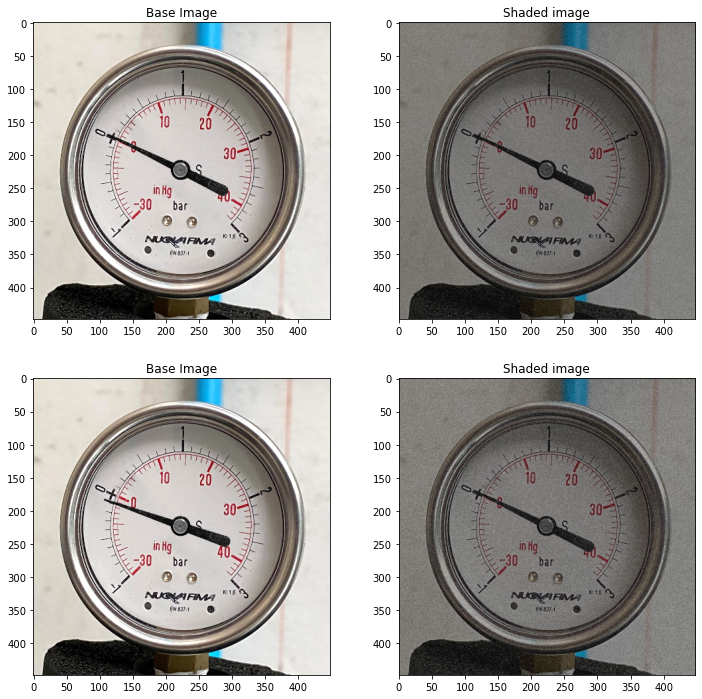

In [ ]:
plt.figure(figsize = (12, 12))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[0])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(gaussian_noise_imgs[0])
plt.title('Shaded image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[1])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(gaussian_noise_imgs[1])
plt.title('Shaded image')
plt.show()

In [43]:
# Collecting of classes and numeric in lists
def condition_gauge(scale, major, minor):
  if scale == -1:
    major.append(-1)
    minor.append(0.0)
  elif scale == 3:
    major.append(3)
    minor.append(0.0)
  elif scale > -1.0 and scale < 1.0:
    major.append(0)
    minor.append(scale)
  elif scale >= 1.0 and scale < 2.0:
    major.append(1)
    minor.append(float("{:.1f}".format(scale-1)))
  else:
    major.append(2)
    minor.append(float("{:.1f}".format(scale-2)))

  return major, minor

In [44]:
filename1 = "gauge_0.png"
path = "../img_prep//tf_gauges/psi_{0}/{1}"
save_path = "../img_prep/prep_gauge384/{0}"

In [24]:
# major = []
# minor = []

# flag = True
# count = 0

# while flag:

#   for j in np.arange(-1, 3+0.1, 0.1):
#     scale_num = "{:.1f}".format(j)
#     int_scale = float(scale_num)
#     X_img = path.format(scale_num, filename1)
#     X_resize = tf_resize_img([X_img])
#     # # resize_image(X_resize, scale_num)
#     # scaled_image(X_resize, scale_num)

#     # Save Resized image
#     count+=1
#     major, minor = condition_gauge(int_scale, major, minor)
#     file_resized = "{0}.jpg".format(count)
#     filename_resized = save_path.format(file_resized)
#     imageio.imwrite(filename_resized, X_resize[0])
    
#     # Scaling
#     scale = np.linspace(0.6, 0.9, 15)
#     scaled_imgs = central_scale_images(X_resize, scale)

#     for i in range(0, len(scale)):
#         count+=1
#         major, minor = condition_gauge(int_scale, major, minor)
#         filename = "{0}.jpg".format(count)
#         filepath = save_path.format(filename)
#         imageio.imwrite(filepath, scaled_imgs[i])
    

    
#     # Translation
#     translated_imgs = translate_images(X_resize)

#     for i in range(0, 64):
#         count+=1
#         major, minor = condition_gauge(int_scale, major, minor)
#         filename = "{0}.jpg".format(count)
#         filepath = save_path.format(filename)
#         imageio.imwrite(filepath, translated_imgs[i])


#     # Rotation
#     rotated = rotate_images(X_resize, -90, 90, 15)

#     for i in range(30):
#         count+=1
#         major, minor = condition_gauge(int_scale, major, minor)
#         filename = "{0}.jpg".format(count)
#         filepath = save_path.format(filename)    
#         imageio.imwrite(filepath, rotated[i])
      


#     # Lighting

#     # major, minor = condition_gauge(int_scale, major, minor)
#     gaussian_noise_imgs = []
#     row, col, _ = X_resize[0].shape
    
#     # Gaussian distribution paramaters
#     mean = 0
#     var = 0.1
#     sigma = var ** 0.5

#     # parameters of method cv.addWeighted
#     ALPHA = np.linspace(0.50, 0.85, 2)
#     BETA = np.linspace(0.2, 0.8, 2)
#     index_gs = 0 # counting of loops

#     for X_img in X_resize:
#         for alpha in ALPHA:
#             for beta in BETA:
#                 gaussian = np.random.random((row, col, 1)).astype(np.float32)
#                 gaussian = np.concatenate((gaussian, gaussian, gaussian), axis=2)
#                 gaussian_img = cv.addWeighted(X_img, alpha, (1-alpha) * gaussian, beta, 0)
#                 gaussian_noise_imgs.append(gaussian_img)
#                 major, minor = condition_gauge(int_scale, major, minor)
#                 count+=1
#                 filename = "{0}.jpg".format(count)
#                 filepath = save_path.format(filename)
#                 imageio.imwrite(filepath, gaussian_noise_imgs[index_gs])
#                 index_gs += 1
                

#     # gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype=np.float32)
    
#     # filename = "{0}.jpg".format(count)
#     # filepath = save_path.format(filename)
#     # imageio.imwrite(filepath, gaussian[0])
    

#     print(count)


#     label = {'Major_scale':major, 'Minor_scale':minor}
#     label = pd.DataFrame(label)
#     label.to_csv('label.csv', index=False)


#     flag = False

# # print(major)
# print("# of all classes",len(major))
# print("Count = ",count)

In [28]:
# import os, glob
 
# dir = "../img_prep/prep_gauge384/"
# for file in os.scandir(dir):
#     os.remove(file.path)

In [48]:
major = []
minor = []

flag = True
count = 0

while flag:

  for j in np.arange(-1, 3+0.1, 0.1):
    scale_num = "{:.1f}".format(j)
    int_scale = float(scale_num)
    X_img = path.format(scale_num, filename1)
    X_resize = tf_resize_img([X_img])
    # # resize_image(X_resize, scale_num)
    # scaled_image(X_resize, scale_num)
    count+=1

    # Save Resized image
    major, minor = condition_gauge(int_scale, major, minor)
    file_resized = "{0}.jpg".format(count)
    filename_resized = save_path.format(file_resized)
    imageio.imwrite(filename_resized, X_resize[0])
    

    # Scaling
    scale = np.linspace(0.6, 0.9, 50)
    scaled_imgs = central_scale_images(X_resize, scale)

    for i in range(0, len(scale)):
        count+=1
        major, minor = condition_gauge(int_scale, major, minor)
        filename = "{0}.jpg".format(count)
        filepath = save_path.format(filename)
        imageio.imwrite(filepath, scaled_imgs[i])



    # Translation
    translated_imgs = translate_images(X_resize)

    for i in range(0, 8):
        count+=1
        major, minor = condition_gauge(int_scale, major, minor)
        filename = "{0}.jpg".format(count)
        filepath = save_path.format(filename)
        imageio.imwrite(filepath, translated_imgs[i])


    # Rotation
    rotated = rotate_images(X_resize, -90, 90, 30)

    for i in range(30):
        count+=1
        major, minor = condition_gauge(int_scale, major, minor)
        filename = "{0}.jpg".format(count)
        filepath = save_path.format(filename)    
        imageio.imwrite(filepath, rotated[i])



    # Lighting
    count+=1
    major, minor = condition_gauge(int_scale, major, minor)
    gaussian = add_gaussian_noise(X_resize)
    filename = "{0}.jpg".format(count)
    filepath = save_path.format(filename)
    imageio.imwrite(filepath, gaussian[0])


    print(count)


    label = {'Major_scale':major, 'Minor_scale':minor}
    label = pd.DataFrame(label)
    label.to_csv('label.csv', index=False)


    flag = False

# print(major)
print("# of all classes",len(major))
print("Count = ",count)

Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0015605788212269545, 1.1328649520874023]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0027776984497904778, 1.1331455707550049]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002502960152924061, 1.1332831382751465]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030500006396323442, 1.1329641342163086]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0015487275086343288, 1.1333333253860474]. Convert im

90


Lossy conversion from float32 to uint8. Range [0.0015663481317460537, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0028994663152843714, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0034240097738802433, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130017544142901

180


Lossy conversion from float32 to uint8. Range [0.0028994663152843714, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476

270


Lossy conversion from float32 to uint8. Range [0.003910258878022432, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002441555727273226, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0017972295172512531, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0012128641828894615, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648

360


Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024627125822007656, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.003533181268721819, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255,

450


Lossy conversion from float32 to uint8. Range [0.0033168646041303873, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648

540


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00367306312546134, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828,

630


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0025751888751983643, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0016513774171471596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0006760535761713982, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00078004889655858

720


Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648,

810


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

900


Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004399050492793322, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906,

990


Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0034629893489181995, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255

1080


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

1170


Lossy conversion from float32 to uint8. Range [0.003291808068752289, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009271681774407625, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001738615334033966, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007310071960091591, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0015663481317460537, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0028994663152843714, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00195594364777207

1260


Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.003730794880539179, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255,

1350


Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0019359812140464783, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255

1440


Lossy conversion from float32 to uint8. Range [0.0038456078618764877, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648

1530


Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906,

1620


Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255,

1710


Lossy conversion from float32 to uint8. Range [0.0020654904656112194, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002182204509153962, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0023046648129820824, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009271681774407625, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001594430417753756, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007310071960091591, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00156634813174605

1800


Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906,

1890


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004690761677920818, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

1980


Lossy conversion from float32 to uint8. Range [0.0017573111690580845, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009271681774407625, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0011154370149597526, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007310071960091591, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0015663481317460537, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001280350610613823, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0015050799120217

2070


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

2160


Lossy conversion from float32 to uint8. Range [0.0009797755628824234, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.003734512720257044, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002110987203195691, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476,

2250


Lossy conversion from float32 to uint8. Range [0.0013649684842675924, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008012602338567376, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0016046315431594849, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002902912674471736, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0026749935932457447, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906

2340


Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0031336680985987186, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906

2430


Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255,

2520


Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002772425301373005, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004635469056665897, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 

2610


Lossy conversion from float32 to uint8. Range [0.0007310071960091591, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0015663481317460537, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0028994663152843714, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0019559436477720737, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0024739541113376617, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0013031156267970

2700


Lossy conversion from float32 to uint8. Range [0.0006267724093049765, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00046689168084412813, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0006744805723428726, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.000806665513664484, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008634127443656325, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008448414737358689, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.000828908290714

2790


Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648,

2880


Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00057129561901092

2970


Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00057129561901092

3060


Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00057129561901092

3150


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

3240


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.002300757449120283, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0031926813535392284, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

3330


Lossy conversion from float32 to uint8. Range [0.004345610737800598, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648,

3420


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

3510


Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004889046773314476, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.00057129561901092

3600


Lossy conversion from float32 to uint8. Range [0.00130311562679708, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0030976017005741596, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.004452990368008614, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.001362513517960906, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0008289082907140255, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0009767233859747648, 1.1333333253860474]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0007800488965585828

3690
# of all classes 3690
Count =  3690
